# Part 1

In [35]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
from collections import Counter
import random
import time
import math
from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt

The idea we pursued to create the graph is the following:
export the data to pandas dataframes, work on the dataframes and then exploit the built in function of networkx to convert the dataframe into a graph.

In [2]:
a_q=pd.read_csv('a2q',sep=' ', names=['u','v','t'])  #answers to questions
c_a=pd.read_csv('c2a',sep=' ', names=['u','v','t'])  #comments to answers
c_q=pd.read_csv('c2q',sep=' ', names=['u','v','t'])  #comments to questions

In [3]:
print(a_q.shape,c_a.shape,c_q.shape)

(17823525, 3) (25405374, 3) (20268151, 3)


In [4]:
#change time to hours
a_q['t'] = a_q['t'].div(3600)
c_a['t'] = c_a['t'].div(3600)
c_q['t'] = c_q['t'].div(3600)

#add type column to dataframes
a_q['type'] = 'a_q'
c_a['type'] = 'c_a'
c_q['type'] = 'c_q'

#add weights column initial value of 1
a_q['weight'] = 1
c_a['weight'] = 1
c_q['weight'] = 1

#sort by time
a_q=a_q.sort_values('t')
c_a=c_a.sort_values('t')
c_q=c_q.sort_values('t')

In [5]:
def time_maxmin(data,min,max): #Retrieve maximum and minimum timestamps of a given dataframe
    m = data['t'].min()
    M = data['t'].max()
    if m < min:
        min = m 
    if M > max:
        max = M
    return min, max

In [6]:
def create_graph(data1,time_window,self_loops=0):
    #remove rows with u=v if we don't want self loops
    if self_loops == 0: 
        data1 = data1[data1['u'] != data1['v']]
    
    #remove rows not having time 't' in given time interval
    data1 = data1[data1['t'].between(time_window[0], time_window[1])]
    
    #assign weight --> 1 for every edge ,+1 every time u,v (interact)
    #also remove multiple links bewtween 2 nodes and leave one that has weight 1+#interactions between the nodes
    D = data1[['u','v']]
    D = D[D.duplicated(keep=False)]
    D = D.groupby(list(D)).apply(lambda x: tuple(x.index)).tolist()
    for d in D:
        ind = list(d)
        val = len(ind)
        drop = ind[:-1]
        data1.at[ind[-1], 'weight'] = val
        data1 = data1.drop(index = drop)
    
    #convert the dataframe into a multi directed graph with attributes of edges being: last time of interaction, type of interaction and weight of interaction
    G = nx.from_pandas_edgelist(data1, 'u', 'v', ['t', 'type', 'weight'], create_using = nx.MultiDiGraph())
    return G

In [7]:
#here we get maximum and minimum timestamps of the whole data
m = 10**(10)
M = 0
m, M = time_maxmin(a_q, m, M)
m, M = time_maxmin(c_a, m, M)
m, M = time_maxmin(c_q, m, M)
print(m, M)

338213.2991666667 404798.1744444444


In [65]:
#obviously choose a time window that's inside (m,M)
time_window = (m, m+1000)
#and create the graphs out of the 3 dataframes
A = create_graph(a_q, time_window)
B = create_graph(c_a, time_window)
C = create_graph(c_q, time_window)

In [66]:
#merge the graphs
G = nx.compose_all([A, B, C])

In [10]:
def drop_edges(G,time_window):
    to_drop=[]
    for u,v,att in G.edges(data=True):
        if not time_window[0] <= att['t'] <= time_window[1]:
            to_drop.append((u, v))
    [G.remove_edge(u,v) for (u,v) in to_drop]
    return G

In [41]:
len(G.edges)

3790

In [42]:
G=drop_edges(G,(m+50,m+100))

In [43]:
len(G.edges)

297

# Part 2

## function 1 

It takes in input:

    One of the 3 graphs

The output should return:

    Whether the graph is directed or not
    Number of users
    Number of answers/comments
    Average number of links per user
    Density degree of the graph
    Whether the graph is sparse or dense


In [47]:
def get_feats(G):
    feats=[] 
    #m = G.number_of_edges()    = n_interactions
    #n = sum(G.nodes)           = n_users
    
    n_interactions = 0
    dir_list = []
    users=[]
    
    for u,v,attr in (G.edges(data=True)):
        if (G.has_edge(v,u)) and (n_interactions<=len(A.edges(data=True))/2) :
            dir_list.append(abs(attr['weight']-G.get_edge_data(72, 9)[0]['weight']))
        
        if u not in users: users.append(u) #update the users list
        if v not in users: users.append(v)

        n_interactions += 1 #count interactions
        
    if all(val == 0 for val in dir_list): direct=False
    else: direct=True
    
    n_users = len(users) #cpount users
     
    avg_links = 0 #initialize values for avg links and density
    density = 0
    g = None
    if n_users>0: 
        avg_links = n_interactions/n_users #just compute a mean
        
        if direct: # we have the 2 cases for directed and undirected graph
            density = 2*n_interactions/(n_users*(n_users-1))
        else:
            density = n_interactions/(n_users*(n_users-1))
                                
        if density>0.5: #this is straightforward: we are defining a graph to be sparse if its density value<0.5 and dense otherwise
            g='dense'
        else:
            g='sparse'
        
    #return list with asked values
    feats.extend((direct, n_users, n_interactions, avg_links, density, g))
    
    return feats

In [48]:
get_feats(G)

[True, 775, 3790, 4.890322580645162, 0.012636492456447445, 'sparse']

## function 2 

It takes in input:

    A user/node
    An interval of time
    One of the following metrics: Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality

The output should return:

    The value of the given metric applied over the complete graph for the given interval of time

Give an explanaition regarding the features of the user based on all of the metrics (e.g. if the betweeness metric is high, what does this mean in practice, what if the betweeness is low but it has a high PageRank value, etc.)

### PageRank (Random surfer model)

To compure PageRank we first create the adjacency matrix of the graph, then build the $P^{RW}$ matrix, and after that we assign $\alpha=0.2$ to create the $P$ matrix using the formula:

Given $n=\#nodes$

$P=\frac{\alpha}{n}M_1+(1-\alpha)P^{RW}$ where $M_1$ is a $nxn$ matrix filled with ones.

After this just compute for a time $T$

In [13]:
def build_adj_matrix(G,n): #create adjacency matrix of the graph
    if n == 0: raise('No nodes found')
    else: #we opted for doing it with a  dictionary in which we store a 1 if there is a edge between the 2 nodes
        ones = {} 
        
        for u,v in sorted(list(G.edges())):
            ones[(u,v)] = 1 
    return ones

In [14]:
def mapper(G): #return dictionary with nodes as keys and index in matrix as value
    conv={}    #maps from nodes to values in matrix, can be used in the other way too
    counter=0
    for u in sorted(G.nodes):
        conv[u]=counter
        counter+=1
    return conv

In [15]:
def no_tp_P(G,mat,mapper,n):
    keys = list(mat.keys())
    c = Counter(u for u,v in keys) #count number of occurances of each node, so we know by what value we have to divide to obtain P^{RW}
    for source in sorted(list(G)):
        for (u,v) in keys:
            if source == u and c[source] > 0:
                mat[(u,v)] = 1/c[source] #we divide by the value here
    keys = list(mat.keys())
    M=np.zeros(shape=(n,n)) #build ndarray (aka matrix of P^{RW}) nxn 
    for (u,v) in keys:
        value=mat[(u,v)]
        i=mapper[u]
        j=mapper[v]
        M[i][j]=value
    return M

In [16]:
def build_P(M, alpha, n): #create the P matrix from given alpha and P^{RW}
    P = (alpha/n * np.ones((n,n))) + ((1-alpha)*(M))   
    return P

In [17]:
def RandomSurfer(G, u, alpha, n, T=100): #T=time, aka n_iterations
    
    print('sit back and relax, this is going to take some time')
    
    #Build P
    mat = build_adj_matrix(G,n) 
    mapp = mapper(G)
    mat = no_tp_P(G,mat,mapp,n)
    P = build_P(mat, alpha, n)
    
    #retrieve index of given node in the matrix
    ind=mapp[u]
    
    #randomize the starting point
    start = random.randint(0,n)
    #retrieve node given its index in amtrix
    key_list = list(mapp.keys())
    val_list = list(mapp.values())
    s = key_list[val_list.index(start)] #s=starting node
    
    print(('starting from node {}').format(s))
    
    #initialize vecotr with all zeros except 1 at starting point
    q0=np.zeros((n,1))
    q0[start]=1
    store_value=[]
    conv=False
    for t in tqdm(range(T)):
        q = np.matmul(q0.T, np.linalg.matrix_power(P, t)) #q_t=q0 * P^t
        if (t>0) and (np.array_equal(q, store_value[-1])):
            print(('converged in {} steps').format(t-1))
            q=store_value[-2] #else we are taking a all zeros array
            conv=True
            break
        store_value.append(q)
    if conv == False: print("didn't converge")
    return q[0][ind]

In [39]:
RandomSurfer(G, 13, 0.2, len(G), T=100)

sit back and relax, this is going to take some time
starting from node 493


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.05it/s]

didn't converge


6.372226103428674e-08

### Closeness

Computed as

$Closeness(v)= \frac{\sum_{u,w\epsilon V \setminus\{v\}} \frac{g_{u,v}^v}{g_{u,v}}}{{n-1 \choose 2}}$

where:
* $g_{u,v}^v = $ # shortest paths between the 2 nodes (u,w) passing through v,
* $g_{u,v} = $ # shortest paths between the 2 nodes (u,w),
* $n = $ # nodes in the graph.

In [18]:
def shortest_path(G,source,target):
    dist = {}
    prev = {}
    nodes_list=[]
    #Initializatio
    for node in nx.nodes(G):
        dist.update({node : math.inf}) # A dict with the nodes and the distances (We initialize all the distances as + infinite)
        prev.update({node : None}) # A dict with the previous node of each node 
        nodes_list.append(node) # A list with the nodes that have not been visited
    dist[source] = 0 # We initialize the distance of the source node as 0
    
    while len(nodes_list) != 0: # We will do the next steps until we'll have visited all the nodes are we'll have found the target node
       
        # the algorithm starts visiting the node with the lower distance
        dist_list =[] 
        for node in nodes_list:
            dist_list.append(dist[node])
        u = nodes_list[dist_list.index(min(dist_list))]
        nodes_list.remove(u) # removing the node from the list of the nodes that have not been visited
        
        #If the visited node il the target stop the visits
        if u == target:
            break
            
        #Otherwise we look at the neighbors
        for neighbor in G.neighbors(u):
            #computing the new distances for all neighbors
            new_dist = dist[u] + G[u][neighbor][0]['weight']
            #If the new distance is lower than the previous one we update di distances dict
            if dist[neighbor] > new_dist:
                dist[neighbor] = new_dist
                prev[neighbor] = u
                
    #If the target has not a previous node it means that there is nott a path (the graph is not connected) so the algorithm
    #returns 'not possible'
    if prev[target] == None:
        return ('Not possible', [-1])
    
    #creating a list with the path from the source node to the target
    path_node = target
    path = [path_node]
    
    while path_node != source:
    
        path.insert(0,prev[path_node])
        path_node = prev[path_node]
    
    #The algorithm returns the distance of the target and the path
    return dist[target], path


In [19]:
def Closeness(G,u,n):
    somma=0
    for v in tqdm(G.nodes):
        dist,path=shortest_path(G,u,v)
        if (dist!='Not possible') and (dist!=0):
            somma+=int(dist)
    #print(somma)
    if somma>0: return ((n-1)/somma)
    else: raise('Error: sum=0')

In [21]:
Closeness(G,13,len(G))

100%|███████████████████████████████████| 775/775 [00:14<00:00, 54.38it/s]


0.5108910891089109

### Betweenness

Computed as

$Betweenness(v)= \frac{n-1}{\sum_{u\epsilon V \setminus\{v\}}d(v,u)}$
where $d(v,u)=$ shortest path distance between (u,v).

In [20]:
def Betweenness(G,q,n):
    print("You chose to use betweenness, we suggest you to go out and take a hangover, you'll be fine before this is over")
    somma_q = 0
    somma = 0
    for u in tqdm(G.nodes):
        for v in (G.nodes):
            dist,path = shortest_path(G,u,v)
            if (dist!='Not possible') and (dist!=0):
                somma+=int(dist)
                if q in path:
                    somma_q+=int(dist)
    
    num = 2*somma_q/somma
    den = n*n - 3*n + 2
    if den>0: return num/den
    else: raise('Error: denominator=0')

In [23]:
Betweenness(G,13,len(G))

You chose to use betweenness, we suggest you to go out and take a hangover, you'll be fine before this is over


100%|█████████████████████████████████| 775/775 [3:22:07<00:00, 15.65s/it]


5.5679844400311824e-08

In [21]:
def functionality_2(G, u, metric, time_interval, alpha=0.2):  #functionality 2: return the queried metric for the given node
    values = functionality_1(G)
    n = values[1]
    G=drop_edges(G,time_interval)
    if metric == 'Betweeness':
        return Betweenness(G,u,n)
    
    elif metric == 'PageRank':
        return RandomSurfer(G, u, alpha, n)
    
    elif metric == 'Closeness':
        return Closeness(G,u,n)
    
    elif metric == 'Degree':
        return (G.degree(int(u))/(n-1))
    
    else:
        raise('Metric not allowed')

In [42]:
functionality_2(G,13,'PageRank',(m,m+1000))

sit back and relax, this is going to take some time
starting from node 1318


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.46it/s]

didn't converge


1.2664142669969493e-08

### Functionality 3

In [22]:
def functionality_3(G,users,source,target):
    s_p = shortest_path(G,source,users[0])
    dist = s_p[0]
    path = s_p[1]
    if dist == 'Not possible':
        return 'Not possible'
    
    for i in range(len(users)-1):
        s_p = shortest_path(G,users[i],users[i+1])
        if s_p[0] == 'Not possible':
            return 'Not possible'
        dist += s_p[0]
        path.extend(s_p[1][1:])
        
    s_p = shortest_path(G,users[-1],target)
    if s_p[0] == 'Not possible':
            return 'Not possible'
        
    dist += s_p[0]
    path.extend(s_p[1][1:]) 
    
   
    return dist,path

In [25]:
functionality_3(G,[2,5],1,8)

'Not possible'

# Part 4

## 4.1

Whether the graph is directed or not
Number of users
Number of answers/comments
Average number of links per user
Density degree of the graph
Whether the graph is sparse or dense

In [49]:
feats=get_feats(G)

In [57]:
def create_table(features):
    table=[['Directed','n_users','tot_interactions','avg links per user','Density degree','type'],features]
    print(tabulate(table,headers='firstrow'))
    return

In [56]:
def plot_degree_hist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees,50,density=True)
    plt.show()
    return


## 4.2

## 4.3

## 4.4

# FUNCTIONALITIES

In [68]:
def functionality_1(G):
    feats=get_feats(G)
    create_table(feats)
    plot_degree_hist(G)

Directed      n_users    tot_interactions    avg links per user    Density degree  type
----------  ---------  ------------------  --------------------  ----------------  ------
True             3183               23081               7.25134        0.00455772  sparse


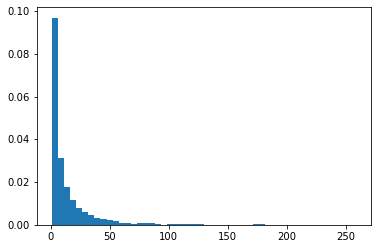

In [67]:
functionality_1(G)